In [ ]:
# Colab setup: install deps and clone repo if needed
!pip -q install geopandas rasterio shapely pyproj xarray h5netcdf scikit-learn seaborn

import os
from pathlib import Path

repo_dir = Path('SGS_training')
if not repo_dir.exists():
    !git clone https://github.com/MinersAI/SGS_training.git
%cd SGS_training

os.environ.setdefault('SGS_PROJECT_ROOT', os.getcwd())
os.environ.setdefault('SGS_DATA_ROOT', str(Path(os.getcwd()) / 'data'))


# SGS Foundational Concepts and Data Preprocessing

Welcome to this training module on geospatial data analysis for mineral exploration. In this notebook, we'll cover the essential groundwork: loading different data types, understanding their formats, and preparing them for analysis.

**What we'll cover:**
- Different geospatial data formats (rasters vs. vectors)
- Exploratory data analysis (EDA) for geochemical data
- Data transformations and why they matter
- Handling missing data
- Understanding spatial autocorrelation and its implications

Let's get started by configuring our data paths and loading the datasets.

-----------

## Imports


In [2]:
import helpers as h

-----------

## Problem Formulation

Before diving into any analysis, it's critical to define what you're trying to achieve. Ask yourself:

- **What's the target?** (e.g., predicting prospectivity, finding anomalies, mapping alteration)
- **What output do you need?** (e.g., a map, ranked target list, geochemical clusters)
- **What constraints exist?** (data quality, resolution, budget for follow-up)

Having a clear objective shapes every decision downstream—from which data to prioritize to which methods make sense.

Some questions we will explore in the analytical methods notebook include:

- *How can we better visualize spatial geochemical species abudance? `(IDW, Kriging)`*
- *What are the dominant geochemical signatures, and which elements vary together? `(PCA)`*
- *Can we group samples into distinct geochemical populations? `(K-means clustering)`*
- *Which samples have unusual multi-element signatures worth investigating? `(Isolation Forest)`*
- *Where are there dense concentrations of various minerals? `(Spectral classification)`*
- *Can we predict prospectivity using known deposits? `(Supervised ML)`*

-----------

## Load Helpers and Prepare Data


In [3]:
data = h.load_training_data()

continuous_raster = data['continuous_raster']
raster_extent = data['raster_extent']
raster_crs = data['raster_crs']
vector_gdf = data['vector_gdf']
categorical_raster = data['categorical_raster']
geochem_gdf = data['geochem_gdf']

feature_cols, value_col = h.prepare_geochem_features(geochem_gdf)
print('Data loaded and ready for preprocessing.')


Raster shape: (351, 396)
Vector records: 463
Geochem records: 1243
Data loaded and ready for preprocessing.


-----------

## Data Format Considerations

Geospatial data comes in two main flavors:

**Vector data** — discrete features with coordinates (points, lines, polygons)
- *Lithology polygons*: boundaries of rock units mapped from fieldwork or remote sensing
- *Geochem points*: sample locations with associated assay values

**Raster data** — continuous grids of pixels, where each pixel holds a value
- *Geophysics*: gridded magnetic, gravity, or radiometric surveys
- *Spectral indices*: satellite-derived maps highlighting specific mineral signatures

Understanding which format your data is in determines how you'll process and analyze it.

Plotting data format examples...


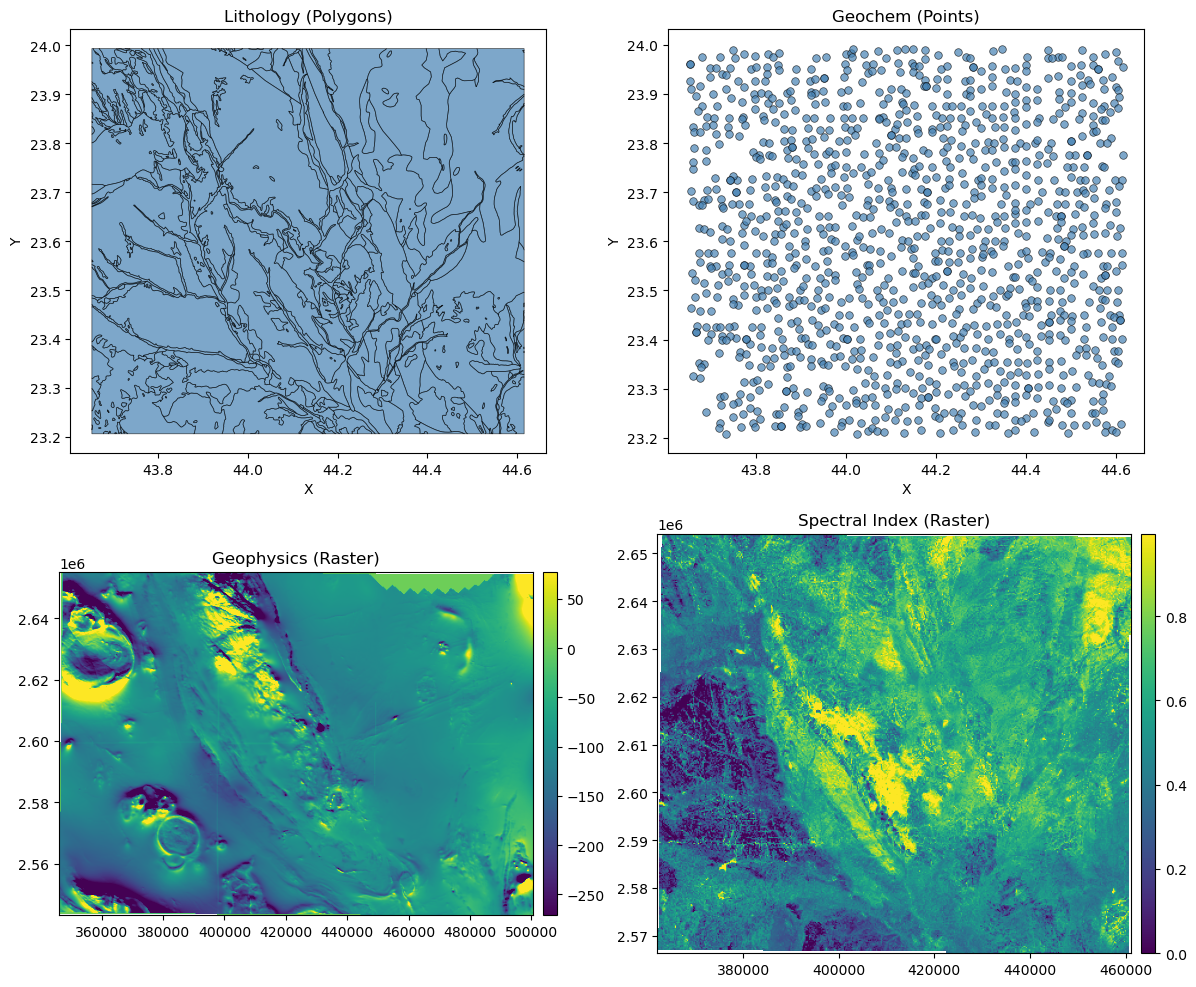

In [4]:
print('Plotting data format examples...')
_ = h.plot_data_format_examples(vector_gdf=vector_gdf, geochem_gdf=geochem_gdf)
h.show_plot()


The top two plots above represent the kinds of vector data we are ingesting - lithologic and geochemical. Both of these data layers contain attributes within them to describe each of the unique features (e.g. lithologic units, geochem samples).

The bottom two plots represent two examples of the raster data we are ingesting - geophysical and spectral. Both are gridded, numeric datasets, where each pixel is assigned a value that relates to the original measurement (e.g. magnetic intensity, spectral reflectance).

The ways in which we can use, interact with, and analyze these two kinds of data differs. Combining varied data formats such as these for ML processing can become quite complex - we will address this later on in our exercise when we reach the Prospectivity Mapping workflow.

-----------

## EDA, Transformations, and Scaling

Exploratory Data Analysis (EDA) is your first look at the data. Before running any sophisticated models, you need to understand:
- What does the distribution look like?
- Are there outliers?
- How do variables relate to each other?

Let's start by getting a high-level summary of our geochemical dataset.

In [5]:
h.summarize_geochem(geochem_gdf, feature_cols)

GEOCHEMICAL DATA SUMMARY

Records: 1243
Total columns: 80
Numeric feature columns: 57

Spatial extent:
  X: 43.65 to 44.62
  Y: 23.21 to 23.99

Element breakdown:
  Major oxides (percent): 9
  Trace elements (ppm): 40
  Trace elements (ppb): 8

Missing data:
  Columns with missing: 0 / 57
  Total missing cells: 0 / 70851 (0.0%)

Sample statistics (first 10 columns):
------------------------------------------------------------
                         Mean        Std        Min        Max
SiO2_percent_xrf    66.536114  10.215087  13.820000  89.580000
Al2O3_percent_xrf   10.331802   2.075366   1.800000  15.750000
TFe2O3_percent_xrf   2.734119   1.897377   0.220000  10.930000
K2O_percent_xrf      2.496806   1.181523   0.380000   5.980000
MgO_percent_icp      1.362043   1.091851   0.090000   9.930000
CaO_percent_icp      6.100957   4.091647   0.450000  31.070000
Na2O_percent_icp     2.281778   0.797186   0.220000   5.080000
TC_percent_irs       0.981126   0.818838   0.080000   8.360000
LOI

This summary tells us:
- **Dataset size:** How many samples and variables we're working with
- **Element types:** Breakdown of major oxides vs. trace elements (important for understanding data scale differences)
- **Spatial extent:** The geographic footprint of our sampling
- **Missing data:** An initial view of data completeness

Now let's look at individual variable distributions.

In [6]:
# --- USER PARAMETERS: Quantile Clipping ---
# Clip extreme values to reduce the influence of outliers on visualizations/analysis.
# Set to None for no clipping, or a tuple like (0.01, 0.99) to clip the bottom 1% and top 1%.
# More aggressive clipping (e.g., 0.05, 0.95) removes more outliers but may hide real anomalies.

clip_quantiles = None  # Try: (0.01, 0.99) or (0.05, 0.95)

In [7]:
print('Preparing distributions for EDA...')
values = geochem_gdf[value_col].values
values = h.clip_quantiles(values, clip_quantiles)

Preparing distributions for EDA...


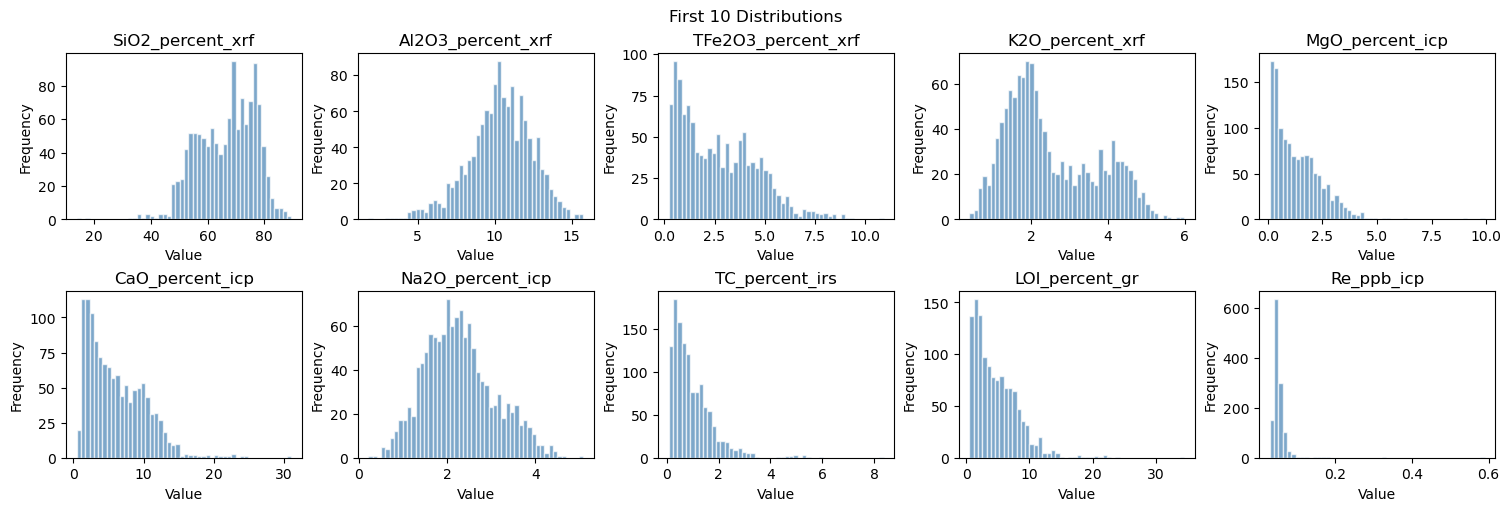

In [8]:
_ = h.plot_distribution(geochem_gdf[feature_cols],
                      title='First 10 Distributions',
                      show_stats=False,
                      max_plots=10,
                      ncols=5)
h.show_plot()


### Interpreting the first 10 distributions

Rather than a single element, these 10 plots show the range of distribution shapes you will commonly see in geochemical data:

- **SiO2_percent_xrf, Al2O3_percent_xrf, K2O_percent_xrf, Na2O_percent_icp:** Broad, near-normal shapes typical of major oxides, with moderate spread.
- **TFe2O3_percent_xrf, CaO_percent_icp:** Right-skewed with long tails, indicating a few higher-value samples.
- **MgO_percent_icp, LOI_percent_gr, TC_percent_irs:** Strongly right-skewed; most samples are low with a small number of enriched values.
- **Re_ppb_icp:** Extremely concentrated near zero with a sharp tail, typical for trace elements near detection limits.

Key takeaway: many geochemical variables are **non-normal** and **right-skewed**, so transformation (e.g., log) is often needed before modeling.


In [9]:
# --- USER PARAMETERS: Data Transformation ---
# Choose how to transform skewed data before analysis.
# 'none'  = no transformation (use raw values)
# 'log1p' = log(1 + x), handles zeros safely and normalizes right-skewed distributions
# Log transforms are common for geochemical data where values span orders of magnitude.

transform = 'log1p'  # Options: 'none', 'log1p'

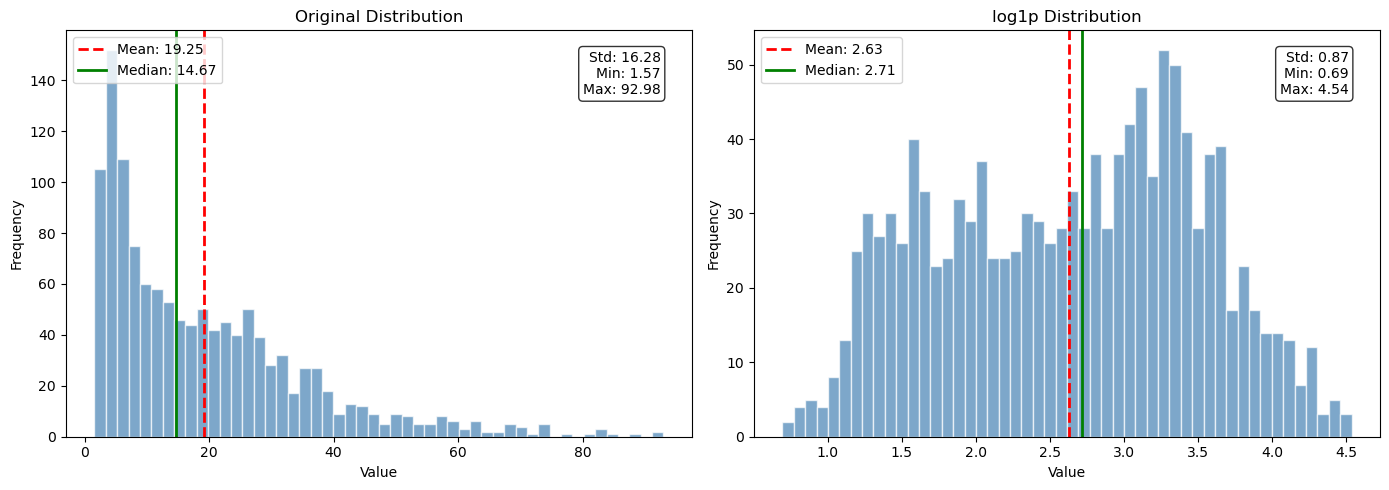

In [10]:
log_values = h.apply_transform(values, transform=transform)
_ = h.plot_transformation_comparison(values, log_values, transform_name=transform)
h.show_plot()

### Why log transformation helps

Compare the two distributions:

**Original (left):** Heavily right-skewed with most values bunched at the low end

**Log-transformed (right):** Much more symmetric, approaching a normal distribution

After transformation:
- Mean (2.63) and Median (2.71) are now nearly equal
- The standard deviation dropped from 16.28 to 0.87
- The spread is more uniform, making patterns easier to detect

**Key point:** We use `log(1 + x)` (log1p) rather than `log(x)` to handle zero values safely. Many analytical methods—regression, PCA, clustering—perform better on normally distributed data.

-----------

### Feature Correlations

Before modeling, it's useful to examine how variables relate to each other. Highly correlated variables carry redundant information—understanding these relationships helps with feature selection and interpreting results.

In [11]:
# --- USER PARAMETERS: Feature Scaling ---
# Whether to standardize features (subtract mean, divide by std dev) before correlation analysis.
# True  = scale features to mean=0, std=1 (recommended for comparing variables on different scales)
# False = use raw values (correlations still work, but visualization may be harder to interpret)
# Scaling is essential when variables have vastly different units (e.g., ppm vs. percent).

scale_features = True  # Options: True, False

Scaling features and examining correlations...


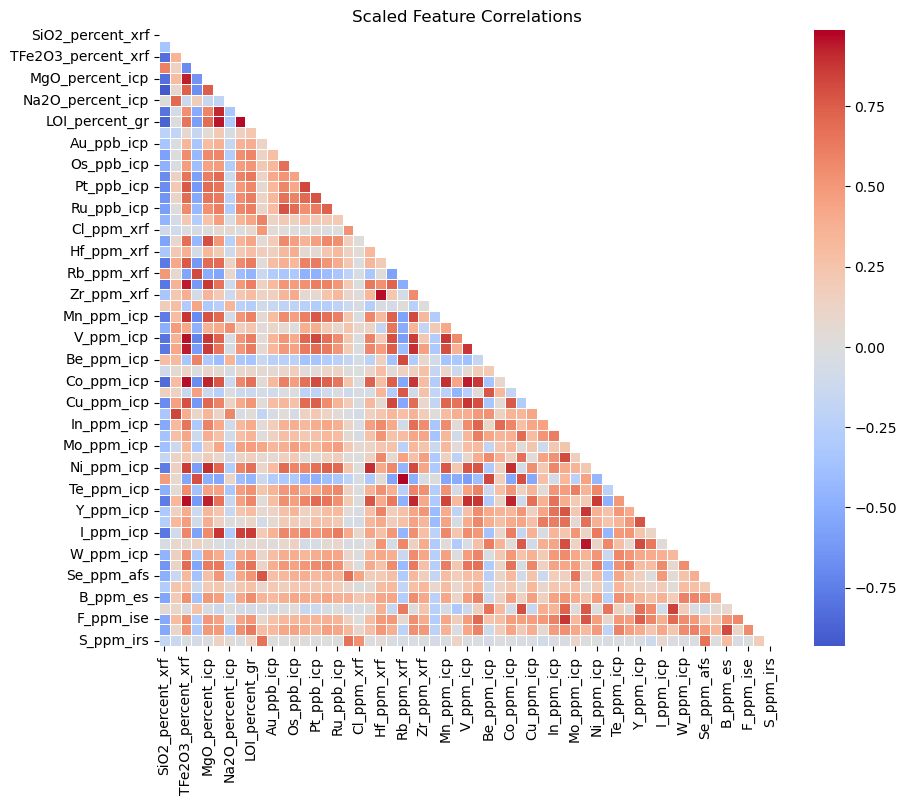

In [12]:
print('Scaling features and examining correlations...')

if scale_features:
    scaled_df, scaler = h.scale_features(geochem_gdf, feature_cols)
else:
    scaled_df = geochem_gdf[feature_cols].copy()
    scaler = None
_ = h.plot_correlation_matrix(scaled_df, title='Scaled Feature Correlations', annot=False)
h.show_plot()

### Reading the correlation matrix

This triangular heatmap shows pairwise correlations between all geochemical variables:
- **Red = positive correlation** (elements that increase together)
- **Blue = negative correlation** (as one increases, the other decreases)
- **White/neutral = no correlation**

**Notable patterns to look for:**
- Strong positive correlations among trace elements (red clusters) often indicate shared geochemical behavior or common mineral hosts
- SiO₂ commonly shows negative correlation with many elements—typical of dilution effects in silica-rich rocks
- LOI (Loss on Ignition) correlations reflect volatile-bearing minerals like clays and carbonates
- Element pairs with very high correlation (|r| > 0.8) may be redundant for modeling purposes

**Why this matters:** This informs feature selection—highly correlated variables carry redundant information. PCA (covered later) is one way to combine correlated variables into independent components.

-----------

## Missing Data and Imputation

Real-world geochemical datasets almost always have missing values. Common causes include:
- Samples not analyzed for certain elements (cost constraints)
- Values below detection limits (sometimes indicated by negative values!)
- Data entry errors or QA/QC failures
- Different analytical packages used across campaigns

Before analysis, we need to:
1. **Understand the pattern** — Is missingness random, or is there structure?
2. **Decide on a strategy** — Drop rows/columns, or fill in (impute) values?

For this demo, we'll artificially inject missing data (0-10% per column, randomly) to illustrate the workflow. Then we'll apply mean imputation as a simple fix.

In [13]:
# --- USER PARAMETERS: Missing Data Simulation ---
# For demonstration, we inject random missing values into the dataset.
# Format: (min_rate, max_rate) - each column gets a random missing % within this range.
# (0, 0.1)  = 0-10% missing per column (light missingness)
# (0.1, 0.3) = 10-30% missing per column (moderate missingness)
# (0.3, 0.5) = 30-50% missing per column (heavy missingness, may require dropping columns)

missing_rate = (0, 0.1)  # Try: (0.1, 0.3) to see more severe missingness patterns

In [14]:
print('Injecting missing values for demo...')
geochem_missing = h.add_missing_data(
    geochem_gdf,
    missing_pct=missing_rate,
    columns=feature_cols,
)

Injecting missing values for demo...


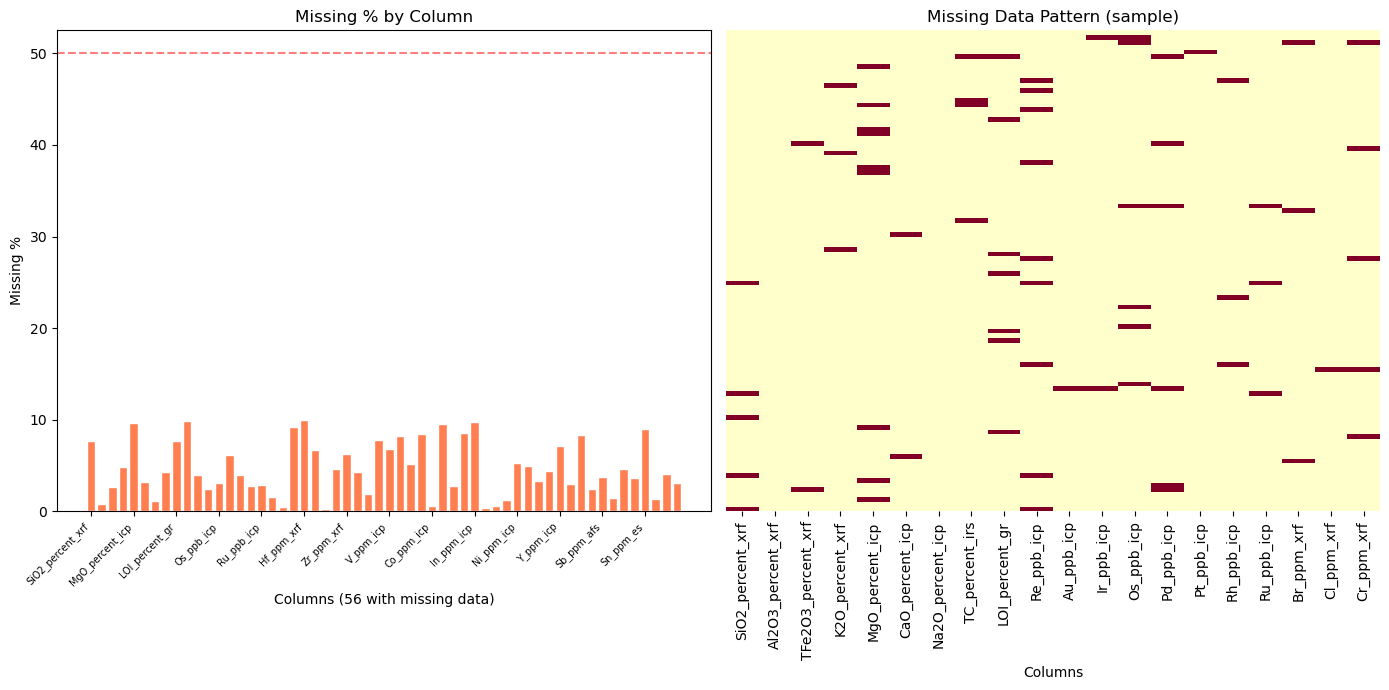

In [15]:
_ = h.plot_missing_data_pattern(geochem_missing[feature_cols], figsize=(14, 7))
h.show_plot()


### Understanding missing data patterns

**Left plot (Missing % by Column):** Shows the percentage of missing values for each variable. Since we injected random amounts (0-10%) per column, you'll see variation across variables. The red dashed line at 50% marks a common threshold—columns above this are often dropped entirely.

**Right plot (Missing Data Pattern):** Each row is a sample, each column is a variable. Dark cells = missing values. This visualization helps identify:
- Whether missingness is random or structured
- If certain samples are missing many values (row patterns)
- If certain variables are systematically missing together (column patterns)

In real data, you might find that PGE (platinum group element) analyses are missing because only some samples were sent for that expensive analysis—that's **not random** missingness and requires different handling.

Now let's fill in these gaps using mean imputation.

In [16]:
# --- USER PARAMETERS: Imputation Strategy ---
# Choose how to fill in missing values.
# 'mean'          = replace missing with the column mean (simple, reduces variance)
# 'median'        = replace missing with the column median (more robust to outliers)
# 'most_frequent' = replace missing with the most common value (better for categorical-like data)
# Mean/median are typical for continuous geochemical data; median is preferred if outliers exist.

impute_strategy = 'mean'  # Options: 'mean', 'median', 'most_frequent'

In [17]:
print(f"Running {impute_strategy} imputation...")
imputed_values, imputer = h.impute_values(
    geochem_missing[feature_cols],
    strategy=impute_strategy,
)
print('Imputation complete')

Running mean imputation...
Imputation complete


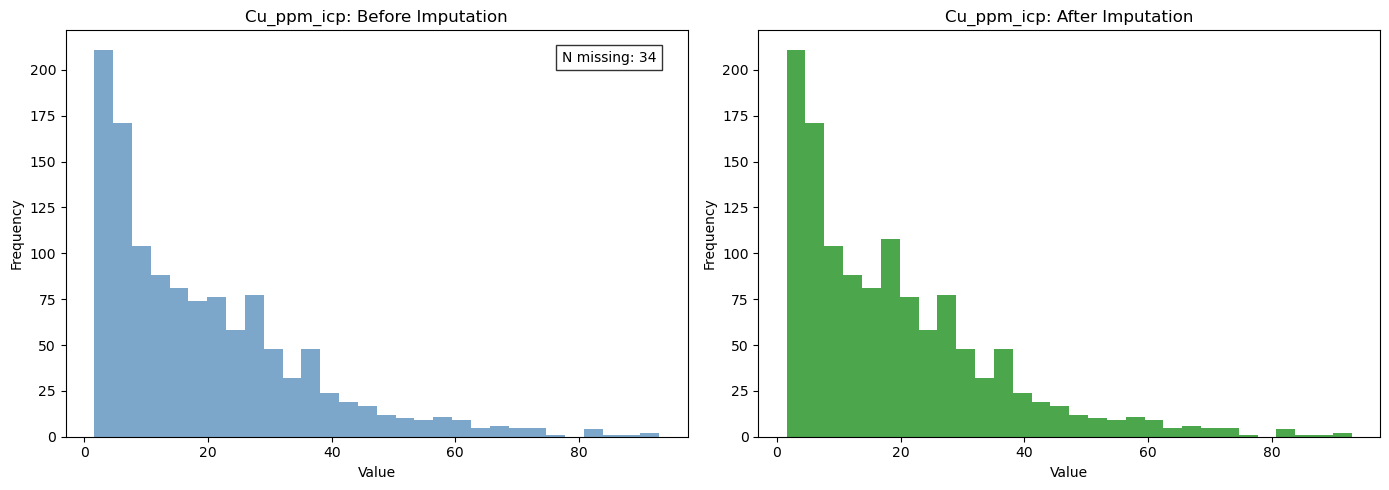

In [18]:
_ = h.plot_imputation_comparison(
    geochem_missing[value_col].values,
    imputed_values[:, feature_cols.index(value_col)],
    column_name=value_col,
)
h.show_plot()


### Imputation results

The above histograms show Cu values before and after imputation:

**Before (blue):** The distribution has its natural shape, with gaps where values were missing.

**After (green):** All samples now have values. The overall distribution shape is preserved because mean imputation doesn't distort the central tendency.

**Caveats:**
- Mean imputation is simple but reduces variance (all imputed values are identical within a column)
- For exploration targeting, this is often acceptable
- More sophisticated methods (KNN imputation, iterative imputation) can preserve more of the data's natural variability

-----------

## Bias and Data Leakage (Spatial Autocorrelation)

Geologic data are often spatially autocorrelated, which inflates model performance when random train/test splits are used. Use spatially aware validation (e.g., block cross-validation or buffered splits) to reduce leakage.

This is a critical understanding for correct application of ML to geospatial data!


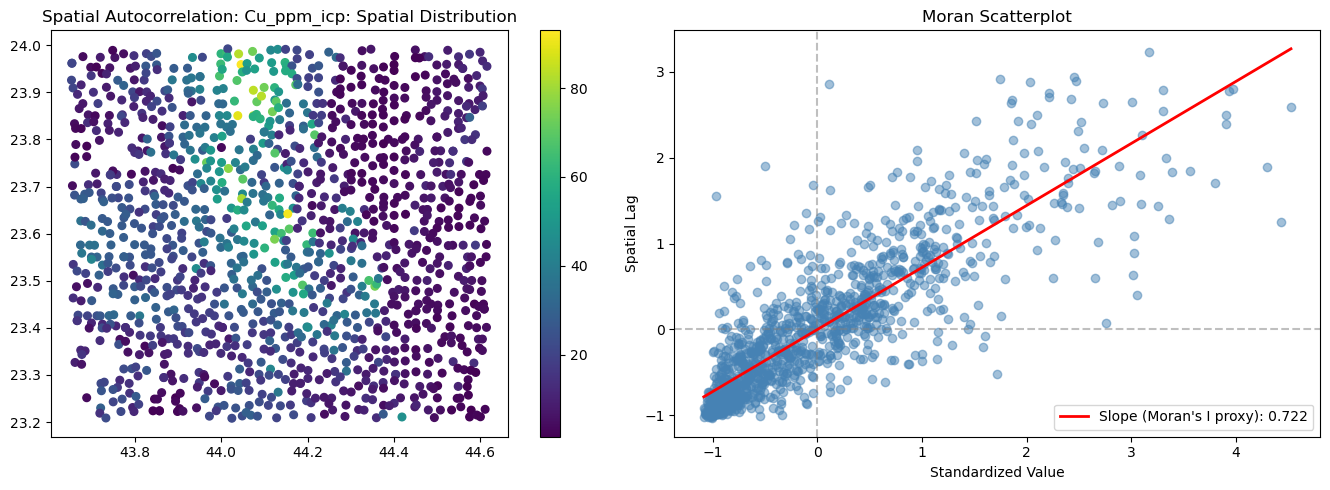

In [19]:
_ = h.plot_spatial_autocorrelation(geochem_gdf, values, title=f'Spatial Autocorrelation: {value_col}')
h.show_plot()


### Interpreting spatial autocorrelation

**Left (Spatial Distribution):** Cu values mapped at sample locations. You can see clustering of high values (yellow/green) in certain areas, particularly in the upper-center portion of the study area.

**Right (Moran Scatterplot):** This diagnostic plot shows:
- X-axis: each sample's standardized Cu value
- Y-axis: the average Cu value of its neighbors (spatial lag)
- The red line's slope (0.722) is a proxy for Moran's I

**Interpretation:**
- Moran's I = 0.722 indicates **strong positive spatial autocorrelation**
- Points cluster in the upper-right (high values surrounded by high neighbors) and lower-left (low values surrounded by low neighbors)
- Very few points in off-diagonal quadrants (which would indicate spatial outliers)

**Bottom line:** This dataset has significant spatial structure. Any ML modeling should account for this to avoid overly optimistic performance estimates.

---

## Summary

In this notebook, we covered the foundational steps of geospatial data analysis:

1. **Data formats:** Vectors (points, polygons) vs. rasters (gridded data)—each requires different handling
2. **EDA:** Always examine your data distributions before analysis
3. **Transformations:** Log transforms help normalize skewed geochemical data
4. **Correlations:** Understanding relationships between variables informs feature selection
5. **Missing data:** Visualize patterns, then choose appropriate imputation strategies
6. **Spatial autocorrelation:** Geologic data is inherently spatially structured—account for this in validation

With clean, well-understood data in hand, we're ready to move on to analytical methods in the next notebook.